<a href="https://colab.research.google.com/github/marcelounb/Deep_learning_book_francois/blob/master/3_6_classifying_newswires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of Deep Learning with Python. Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.


---



In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. But what happens when you have more than two classes?
In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

**The Reuters dataset**

We will be working with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.
Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


Like with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.
We have 8,982 training examples and 2,246 test examples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

In [5]:
train_data.shape

(8982,)

In [6]:
# As with the IMDB reviews, each example is a list of integers (word indices):
train_data

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
       list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110,

In [7]:
# Here's how you can decode it back to words, in case you are curious:

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".

557056/550378 [==============================] - 0s 0us/step


In [0]:
from random import randrange

In [9]:
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[randrange(0,500)]])
decoded_newswire

"? shr profit seven cts vs n a net profit 587 000 vs profit 3 231 000 sales 18 5 mln vs 18 7 mln nine mths shr loss 39 ct s vs n a net loss 2 368 000 vs ? 7 165 000 sales 55 4 mln vs 54 2 mln note current nine month figures include extraordinary loss of 1 2 mln dlrs or 17 cts per share resulting from costs associated with restructuring prior quarter and nine month per share figures not applicable because company began operations in october 1986 with the acquisition of gould inc's lt ? medical products group reuter 3"

# Preparing the data
We can vectorize the data with the exact same code as in our previous example:

In [0]:
import numpy as np

In [0]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [31]:
only_2test_label = np.array([3,3,1,2,3,1,1,0,0,4])
only_2test_label

array([3, 3, 1, 2, 3, 1, 1, 0, 0, 4])

In [34]:
only_2test_vectorize_label = vectorize_sequences(only_2test_label, 5) # The number 5 here sets the dimension to 5 (from 0 to 4). Default is 10.000
only_2test_vectorize_label

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [0]:
# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [25]:
only_2test_label = np.array([3,3,1,2,3,1,1,0,0,4])
only_2test_label

array([3, 3, 1, 2, 3, 1, 1, 0, 0, 4])

In [26]:
only_2test_one_hot_label = to_one_hot(only_2test_label, 5)  # The number 5 here sets the dimension to 5 (from 0 to 4). Default is 46
only_2test_one_hot_label

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [0]:
# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [0]:
# VERY IMPORTANT !!!! BUILT IN WAY TO HOT ENCODE !!!!!
# ----------------------------------------------------
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

# Building our network

This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the dimensionality of the output space is much larger.

In a stack of Dense layers like what we were using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [0]:
from keras import models
from keras import layers

In [0]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

There are two other things you should note about this architecture:


*   We are ending the network with a Dense layer of size 46. This means that for each input sample, our network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
*   The last layer uses a softmax activation. You have already seen this pattern in the MNIST example. It means that the network will output a probability distribution over the 46 different output classes, i.e. for every input sample, the network will produce a 46-dimensional output vector where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.

The best loss function to use in this case is categorical_crossentropy. It measures the distance between two probability distributions: in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [40]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 247us/step - loss: 2.6944 - accuracy: 0.5323 - val_loss: 1.7868 - val_accuracy: 0.6380
Epoch 2/20
7982/7982 [==============================] - 1s 116us/step - loss: 1.4463 - accuracy: 0.7042 - val_loss: 1.3073 - val_accuracy: 0.7310
Epoch 3/20
7982/7982 [==============================] - 1s 118us/step - loss: 1.0602 - accuracy: 0.7839 - val_loss: 1.1405 - val_accuracy: 0.7530
Epoch 4/20
7982/7982 [==============================] - 1s 119us/step - loss: 0.8311 - accuracy: 0.8290 - val_loss: 1.0316 - val_accuracy: 0.7950
Epoch 5/20
7982/7982 [==============================] - 1s 119us/step - loss: 0.6629 - accuracy: 0.8646 - val_loss: 0.9849 - val_accuracy: 0.8010
Epoch 6/20
7982/7982 [==============================] - 1s 118us/step - loss: 0.5298 - accuracy: 0.8886 - val_loss: 0.9237 - val_accuracy: 0.8120
Epoch 7/20
7982/7982 [==============================] - 1s 120us/step - loss

In [42]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Let's display its loss and accuracy curves:

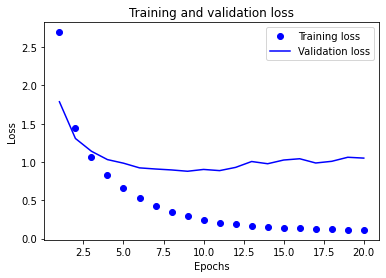

In [43]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

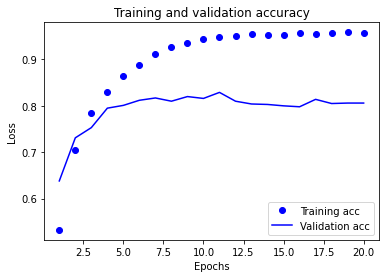

In [45]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on the test set:

In [46]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 139us/step - loss: 2.7610 - accuracy: 0.5179 - val_loss: 1.8389 - val_accuracy: 0.6430
Epoch 2/8
7982/7982 [==============================] - 1s 128us/step - loss: 1.4707 - accuracy: 0.7141 - val_loss: 1.3356 - val_accuracy: 0.7170
Epoch 3/8
7982/7982 [==============================] - 1s 126us/step - loss: 1.0633 - accuracy: 0.7756 - val_loss: 1.1528 - val_accuracy: 0.7590
Epoch 4/8
7982/7982 [==============================] - 1s 124us/step - loss: 0.8327 - accuracy: 0.8254 - val_loss: 1.0578 - val_accuracy: 0.7880
Epoch 5/8
7982/7982 [==============================] - 1s 124us/step - loss: 0.6569 - accuracy: 0.8675 - val_loss: 0.9960 - val_accuracy: 0.7970
Epoch 6/8
7982/7982 [==============================] - 1s 123us/step - loss: 0.5298 - accuracy: 0.8933 - val_loss: 0.9448 - val_accuracy: 0.8100
Epoch 7/8
7982/7982 [==============================] - 1s 125us/step - loss: 0.425

In [47]:
results

[1.0019454807441148, 0.7858415246009827]

Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [48]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1861086375779163

# Generating predictions on new data
We can verify that the predict method of our model instance returns a probability distribution over all 46 topics. Let's generate topic predictions for all of the test data:

In [0]:
predictions = model.predict(x_test)

In [50]:
# Each entry in predictions is a vector of length 46:
predictions[0].shape

(46,)

In [51]:
# The coefficients in this vector sum to 1:
np.sum(predictions[0])

1.0

In [52]:
# The largest entry is the predicted class, i.e. the class with the highest probability:
np.argmax(predictions[0])

3

# A different way to handle the labels and the loss
We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such: